# Imports

In [1]:
# Regular imports
import os
import numpy as np
# Scipy imports
from scipy.stats import linregress
from scipy.optimize import curve_fit
# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
# Image processing imports
import cv2
from skimage import measure, exposure
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops, regionprops_table
from skimage.draw import ellipse_perimeter, line, rectangle

# Directories and Experimental Parameters

In [2]:
# This script assumes to be run in the directory containing the corresponding datarepo folders
COALESCENCE_EVENTS_A = os.getcwd() + "/Coalescence_Events_A/"
COALESCENCE_EVENTS_B = os.getcwd() + "/Coalescence_Events_B/"

# INSERT ABSOLUTE PATH TO SAVE RESULTS IN
RESULTS_DIR = "/ABSOLUTE/PATH/TO/RESULTS/"

In [3]:
# Create array of timepoints names `timepoints`
# For us, this reflects the uneven sampling (every 15min for 10h, then every 30min for remaining 38h)
NUM_TIMEPOINTS_EARLY_SPACING = 41 # 41 timepoints at fast sampling (for 10h)
NUM_TIMEPOINTS_LATE_SPACING = 77 # 77 timepoints at slow sampling (from 10h until end of measurement)
SAMPLING_CHANGE_TIMEPOINT = 10*60 
TIME_WINDOW_END = 48.5*60

timepoints = np.concatenate(
    [np.linspace(0, SAMPLING_CHANGE_TIMEPOINT, NUM_TIMEPOINTS_EARLY_SPACING), 
    np.linspace(SAMPLING_CHANGE_TIMEPOINT + 30, TIME_WINDOW_END, NUM_TIMEPOINTS_LATE_SPACING)],
    axis = 0
)

# Helper functions

In [4]:
def get_initial_avg_size(
    image, 
    pixel_to_micron_conversion = 3.0852
): 
    """
    :par image: single image of sintering/fusing droplets, 
    :par pixel_to_micron_conversion: 
        default is the one for DiMicheleLab 20x lens (from ND2 metadata) -- CHANGE TO MATCH YOUR SETUP!
    
    :returns: average size as characteristic length.
    
    Uses unsupervised Otsu thresholding (skimage.filters.threshold_otsu)   
    """
    
    # compute threshold
    thresh = threshold_otsu(image)
    # binarise
    binary = image > thresh
    
    # get object labels - there are at least two, i.e. the ones that are going to fuse + background
    labels = measure.label(binary)
    
    # Find the two labels that correspond to our two objects
    # Most frequent label = background
    # Get second most common label = 1st droplet
    freq = np.bincount(labels.reshape(-1))
    target_label_idx1 = np.argmax(freq == np.sort(freq)[-2])
    target_label1 = np.array(
        [i if i == target_label_idx1 else 0 
         for i in list(labels.reshape(-1))], 
        dtype = np.uint8
    ).reshape(image.shape[0], image.shape[1])
    
    # Get third most common label = 2nd droplet
    target_label_idx2 = np.argmax(freq == np.sort(freq)[-3])
    target_label2 = np.array(
        [i if i == target_label_idx2 else 0 
         for i in list(labels.reshape(-1))], 
        dtype = np.uint8
    ).reshape(image.shape[0], image.shape[1])
    
    # Compute properties (props) using skimage.measure.regionprops_table
    props = [regionprops_table(label, 
                               properties=('centroid',
                                           'orientation',
                                           'axis_major_length',
                                           'axis_minor_length')) 
             for label in [target_label1, target_label2]
            ]
    # Get sizes as average of the two major axes
    sizes = np.array(
        [
            (props[i]['axis_major_length'][0] + props[i]['axis_minor_length'][0])/2 
            for i in [0, 1]
        ]
    )
    
    # Compute and return mean of those sizes as characteristic length of sintering droplets (l_c)
    l_c = np.mean(sizes/pixel_to_micron_conversion)
    return l_c

In [5]:
def get_region_labels(event):
    """
    Get label of sintering droplet complex given a fusion event.
    :par event: fusion event (timelapse, i.e. sequence of images)
    
    :returns target_labels: 
    """
    # Get shape of each image (all identical in an event)
    image_shape = event[0].shape
    # measure thresholded image (image > threshold)
    labels_list = [
        measure.label(image > threshold_otsu(image)) 
        for image in event
    ]
    # get target labels only
    freqs = [np.bincount(label.reshape(-1)) for label in labels_list]
    # find second most frequent index = larger and most important label after background label
    # after first fusion contact, there is only ONE object of interest
    target_label_idxs = [np.argmax(freq == np.sort(freq)[-2]) for freq in freqs]
    # get most frequent label == target
    target_labels = []
    for label, idx in zip(labels_list, target_label_idxs):
        target_labels.append(np.array(
            [i if i == idx else 0 
             for i in list(label.reshape(-1))],
            dtype = np.uint8
        ).reshape(image_shape[0], image_shape[1]))
    return target_labels

In [6]:
def enhance_contrast(
    img, 
    perc = 0.2
):
    """
    Enhances contrast via skimage.exposure using contrast-stretching method
    
    :par img: image
    :par perc: percentage of pixels to saturate in contrast-strethed image
        - default: 0.2%
    
    :returns img_rescale (contrast-enhanced image)
    """
    p_low, p_high = np.percentile(img, (perc, 100-perc))
    img_rescale = exposure.rescale_intensity(img, in_range=(p_low, p_high))
    return img_rescale

In [7]:
def draw_ellipses_initial_condition(
    image, 
    props, 
    channels
): 
    """
    Draw the best-fit ellipse for the initial condition ONLY (single image)
    :par image: image to draw best-fit ellipse on
    :par props: properties of the segmented image
    :par channels: channels which are non-zero (e.g. for us: A - red, B - cyan)
    """
    # Contrast-enhance image
    img = enhance_contrast(image)
        
    # Convert image to RGB where image is either red or blue channel
    channel_images = {}
    for channel in channels.keys(): 
        if channels[channel] == True:
            channel_images[channel] = np.array(img)
        else: 
            # for missing channels, just create blank images (all zeros)
            channel_images[channel] = np.zeros(img.shape[:2], dtype="uint8")
    
    # Merge channels into RGB image for use with cv2 below
    img_colour = cv2.merge([channel_images['red'],
                           channel_images['green'], 
                           channel_images['blue']])
    
    for droplet, colour in zip([0, 1], [[0, 255, 255], [0, 0, 255]]): 
        # Get properties we need
        major_axis_length = props[droplet]['axis_major_length']
        minor_axis_length = props[droplet]['axis_minor_length']
        centroid_row, centroid_col = props[droplet]['centroid-0'], props[droplet]['centroid-1']
        orientation = np.pi/2 - props[droplet]['orientation']

        # Draw ellipse perimeter and set colour
        rr, cc = ellipse_perimeter(int(centroid_row), int(centroid_col),
                                   int(minor_axis_length/2), int(major_axis_length/2),
                                   orientation=orientation, shape=event[index].shape)
        img_colour[rr, cc] = colour

        # Draw major axis line
        rr_major, cc_major = line(int(centroid_row - 0.5 * major_axis_length * np.sin(orientation)),
                                  int(centroid_col - 0.5 * major_axis_length * np.cos(orientation)),
                                  int(centroid_row + 0.5 * major_axis_length * np.sin(orientation)),
                                  int(centroid_col + 0.5 * major_axis_length * np.cos(orientation)))
        img_colour[rr_major, cc_major] = colour

        # Draw minor axis line
        rr_minor, cc_minor = line(int(centroid_row - 0.5 * minor_axis_length * np.cos(orientation)),
                                  int(centroid_col + 0.5 * minor_axis_length * np.sin(orientation)),
                                  int(centroid_row + 0.5 * minor_axis_length * np.cos(orientation)),
                                  int(centroid_col - 0.5 * minor_axis_length * np.sin(orientation)))
        img_colour[rr_minor, cc_minor] = colour
    return img_colour

def draw_ellipse_fit(
    event, 
    props, 
    channels, 
    label, 
    number, 
    pixel_to_micron_conversion = 3.0852, 
    plot=False,
):
    """
    Parameters:
    :par event: coalescence event timelapse
    :props: properties of segmented regions
    :par channels: channels which are non-zero (e.g. for us: A - red, B - cyan)
    :par label: nametag to save images
    :par number: corresponds to coalescence file number, used with nametag above to save images
    :par pixel_to_micron_conversion: pixel calibration - default value: 20x lens DiMicheleLab
        CHANGE THIS TO MATCH YOUR SETUP
        
    :returns images: COLLECTION of coalescence event images with best-fit ellipses drawn
    """
    # Initialise results
    images = []
    
    # Loop through images in coalescence event
    for index in range(len(event)): 
        # Get image from event
        img = enhance_contrast(event[index])
        
        # Convert image to RGB where image is either red or blue channel
        channel_images = {}
        for channel in channels.keys(): 
            if channels[channel] == True:
                channel_images[channel] = np.array(img)
            else: 
                # for missing channels, just create blank images (all zeros)
                channel_images[channel] = np.zeros(img.shape[:2], dtype="uint8")
                
        # Merge channels into RGB image for use with cv2 below
        img_colour = cv2.merge([channel_images['red'],
                               channel_images['green'], 
                               channel_images['blue']])
        
        # Get properties we need
        major_axis_length = props[index]['axis_major_length']
        minor_axis_length = props[index]['axis_minor_length']
        centroid_row, centroid_col = props[index]['centroid-0'], props[index]['centroid-1']
        orientation = np.pi/2 - props[index]['orientation']
        
        # Draw ellipse perimeter
        rr, cc = ellipse_perimeter(int(centroid_row), int(centroid_col),
                                   int(minor_axis_length/2), int(major_axis_length/2),
                                   orientation=orientation, shape=event[index].shape)
        img_colour[rr, cc] = [255, 255, 255]
        
        # Draw major axis line
        rr_major, cc_major = line(int(centroid_row - 0.5 * major_axis_length * np.sin(orientation)),
                                  int(centroid_col - 0.5 * major_axis_length * np.cos(orientation)),
                                  int(centroid_row + 0.5 * major_axis_length * np.sin(orientation)),
                                  int(centroid_col + 0.5 * major_axis_length * np.cos(orientation)))
        img_colour[rr_major, cc_major] = [255, 255, 255]

        # Draw minor axis line
        rr_minor, cc_minor = line(int(centroid_row - 0.5 * minor_axis_length * np.cos(orientation)),
                                  int(centroid_col + 0.5 * minor_axis_length * np.sin(orientation)),
                                  int(centroid_row + 0.5 * minor_axis_length * np.cos(orientation)),
                                  int(centroid_col - 0.5 * minor_axis_length * np.sin(orientation)))
        img_colour[rr_minor, cc_minor] = [255, 255, 255]
    
        # draw scale bar for first image of the series - 15 um
#         if index == 0: 
#             size_um = 15
#             size_px = int(size_um * pixel_to_micron_conversion)
#             thickness_px = 10
#             rr, cc = rectangle(start = [img.shape[0] - 10 - thickness_px, 10], 
#                                        end = [img.shape[0] - 10, 10 + size_px])
#             img_colour[rr, cc] = [255, 255, 0] #red+green = yellow
        
        # Append to growing image list
        images.append(img_colour)
    if plot: 
        # Plot entire fusion event
        plt.subplots(1, len(images), figsize = (len(images)*6, 6))
        for i in range(len(images)):
            plt.subplot(1, len(images), i+1)
            plt.imshow(images[i], cmap = 'gray')
            plt.axis('off')
    # CHECK THAT YOU HAVE DEFINED RESULTS_DIR TERMINATING WITH `/`
    # Save results
    plt.savefig(RESULTS_DIR + 'sintering' + str(label) + '_' + str(number)+'.svg')
    plt.show()
    return images 

In [8]:
# Define exponential decay for fitting
def exponential(t, a, tau):
    """
    Simple exponential decay
    :par t - time
    :par a - amplitude scaling
    :par tau - time decay constant
    """
    return 1+ a*np.exp(-t/tau)

In [9]:
def pipeline(event_files, event_ranges, colour, label, channels, plot=False): 
    # Initialise time constants (tau) and initial sizes (characteristic size l_c)
    taus, initial_sizes = [], []

    # Loop through the fusion event files
    for index, (event_file, event_range) in enumerate(zip(event_files, event_ranges)): 
        # Get characteristic length (l_c) from before the sintering event
        initial_size = get_initial_avg_size(
            cv2.imreadmulti(event_file)[1][event_range[0]-1]
        )
        initial_sizes.append(initial_size)
        print("Initial size [um] = ", initial_size)

        # Extract relevant time range from event file
        event = cv2.imreadmulti(event_file)[1][event_range[0]:event_range[-1]]

        # Get segmentation labels
        labels_list = get_region_labels(event)

        # Compute geometrical properties, including major and minor axis lengths
        props = [
            regionprops_table(label, properties=('centroid',
                                                 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length')
                             ) 
            for label in labels_list
        ]

        # Compute aspect ratio from major and minor axis length
        ARs = [
            props[i]['axis_major_length'][0]/props[i]['axis_minor_length'][0] for i in range(len(props))
        ]

        max_timepoint = np.max(
            timepoints[event_range[0]:event_range[-1]] - timepoints[event_range[0]]
        )
        # Prepare plot
        plt.figure(figsize = (6, 3))
        # Plot raw datapoints
        plt.plot(
            timepoints[event_range[0]:event_range[-1]] - timepoints[event_range[0]], 
            ARs, 
            'o', 
            color = colour, 
            ms = 10, 
            label = 'Data'
        )
        # Fit exponential decay
        params, pcov = curve_fit(
            exponential, 
            timepoints[event_range[0]:event_range[-1]] - timepoints[event_range[0]], 
            np.array(ARs), 
            p0 = [ARs[0] - 1, 25]
        )
        # Plot fitted profile
        plt.plot(
            timepoints[event_range[0]:event_range[-1]] - timepoints[event_range[0]], 
            exponential(
                timepoints[event_range[0]:event_range[-1]] - timepoints[event_range[0]], 
                params[0], 
                params[1]
            ), 
            color = 'gray', 
            ls = '--', 
            lw = 2, 
            label = 'Fit'
        )
        plt.xlabel('Time [min]', fontsize = 20)
        plt.xticks(
            np.arange(0, max_timepoint, 30), 
            [str(int(i)) if i%2 == 0 else '' for i in np.arange(0, max_timepoint, 30)],
            fontsize = 20
        )
        plt.ylabel('Aspect Ratio [a.u.]', fontsize = 20)
        plt.yticks([1, 1.25, 1.5, 1.75, 2, 2.25], [1, '', 1.5, '', 2, ''], fontsize = 20)
        plt.ylim([0.75, 2.50])
        ax = plt.gca()
        ax.tick_params(direction = 'in', length = 6)
        plt.legend(frameon = False, fontsize = 20)

        # Append computed time constant to list
        taus.append(params[1])

        # Show best-fit ellipses
        images_ellipse = draw_ellipse_fit(
            event, 
            props, 
            channels = channels, 
            label = label, 
            number = index, 
            plot=plot,
        )
        
    return initial_sizes, taus

# A condensates

Initial size [um] =  18.935277362178546


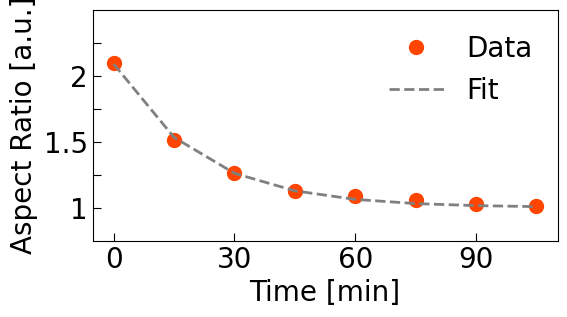

Initial size [um] =  16.85991011574242


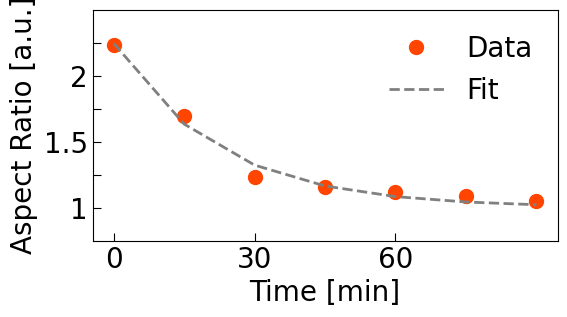

Initial size [um] =  48.198626227508974


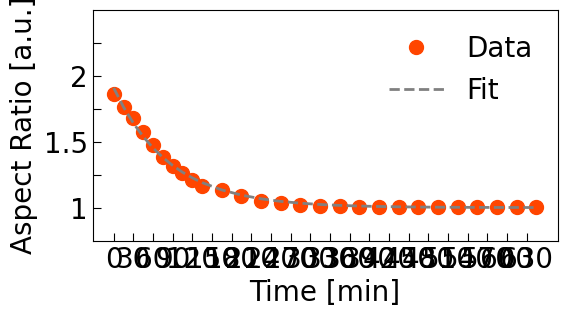

Initial size [um] =  46.72270436231971


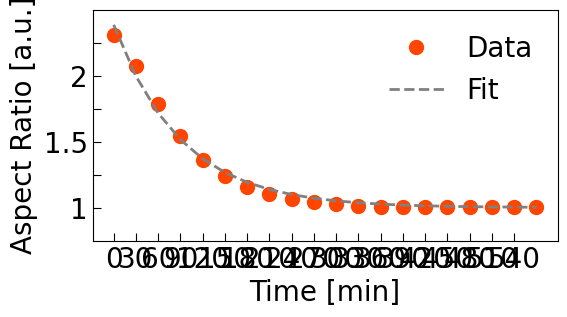

Initial size [um] =  84.83451634848893


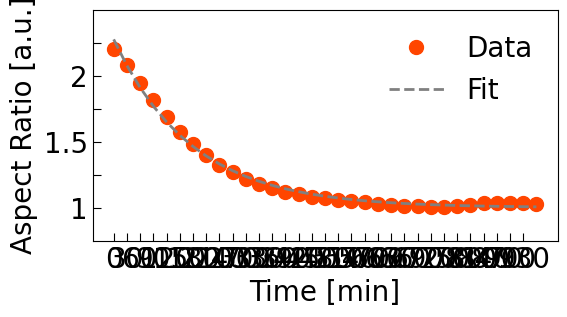

Initial size [um] =  25.851600253250894


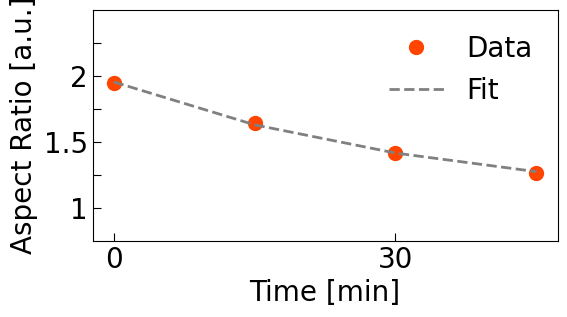

Initial size [um] =  20.17388700177804


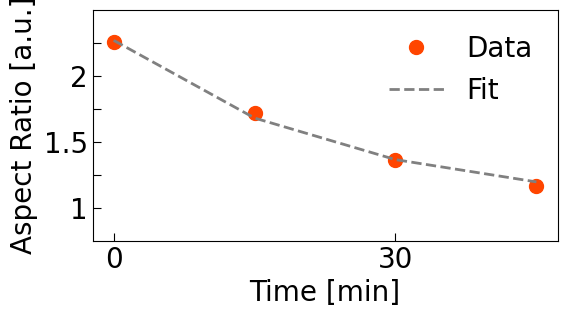

Initial size [um] =  44.47119756331232


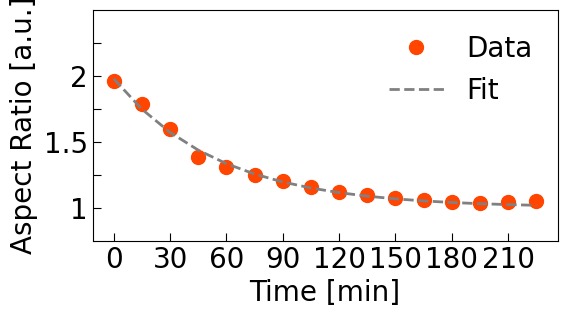

Initial size [um] =  39.733839779045645


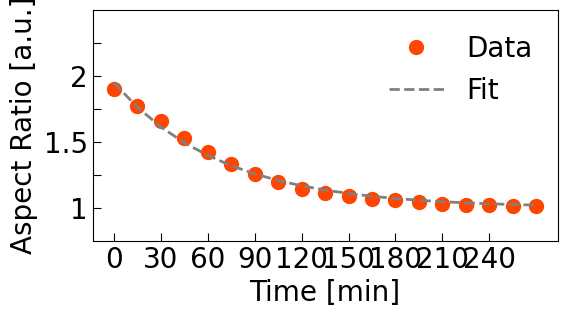

Initial size [um] =  83.70635877542315


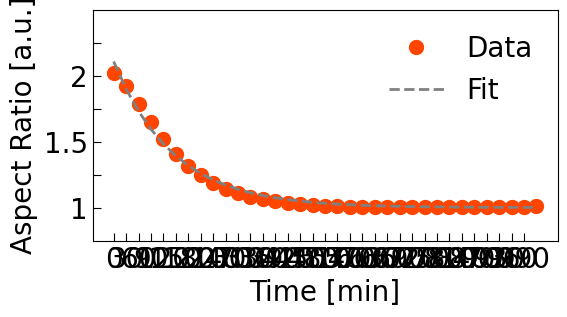

In [10]:
# Change directory into subdir of choice - here coalescence events for A condensates
os.chdir(COALESCENCE_EVENTS_A)

# Define files of interest
event_files_a = [
    'Coalescence_A_0a_6_16-1.tif', 
    'Coalescence_A_0b_6_16.tif', 
    'Coalescence_A_2_28_48.tif', 
    'Coalescence_A_3_48_61.tif', 
    'Coalescence_A_4_81_118.tif', 
    'Coalescence_A_1_9_13.tif', 
    'Coalescence_A_1_6_10.tif', 
    'Coalescence_A_1_15_31.tif', 
    'Coalescence_A_1_19_38.tif', 
    'Coalescence_A_1_52_87.tif'
]
# Here, each file is as long as a pristine timelapse, but only contains the (manually) cropped region
# surrounding the pair of fusing droplets
# However, the fusion event is not that long!
# Manually checked the time ranges of the fusion event in each file -> event_ranges
# These are indices of timepoints, not time values themselves.
# Ranges in `event_ranges` are paired with `event_files`
event_ranges_a = [
    range(7, 16), 
    range(6, 14), 
    range(31, 59), 
    range(48, 69), 
    range(83, 117), 
    range(8, 13), 
    range(5, 10), 
    range(14, 31), 
    range(18, 38), 
    range(51, 87)
]

initial_sizes_a, taus_a = pipeline(
    event_files_a, event_ranges_a, 
    colour='orangered', label='A', 
    channels = {'red': True, 'green' : False, 'blue' : False}, 
    plot=False,  # change to plot ellipse fits for coalescence events
)

# B condensates

Initial size [um] =  14.365977254958928


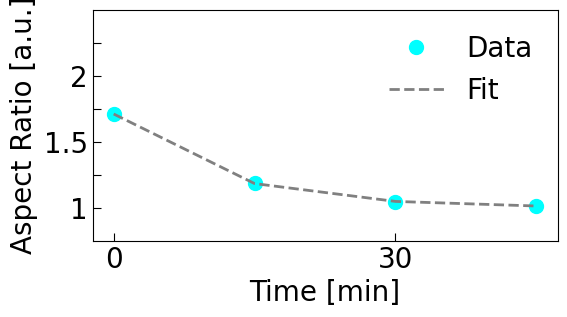

Initial size [um] =  13.633414877431413


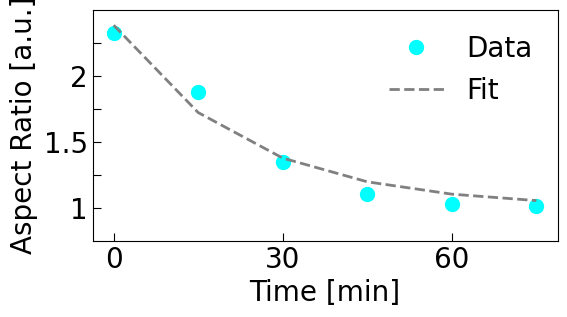

Initial size [um] =  30.894453744205393


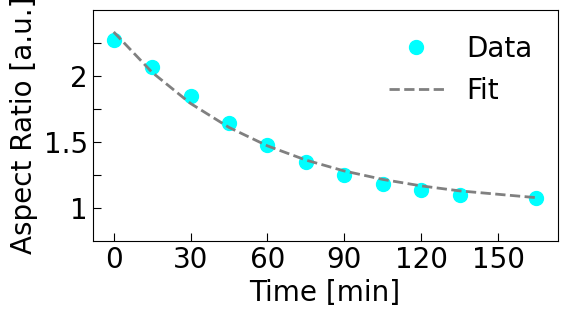

Initial size [um] =  68.34694842719054


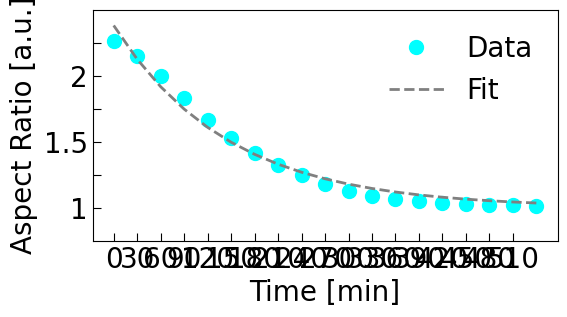

Initial size [um] =  67.80192256266055


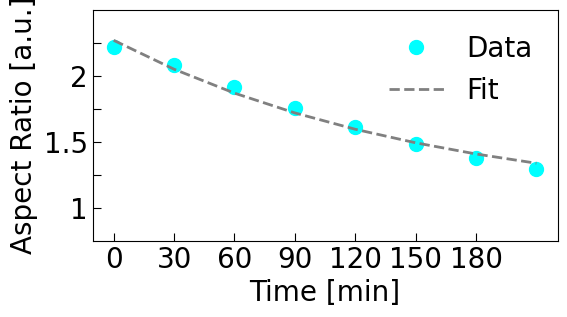

Initial size [um] =  14.94055047466728


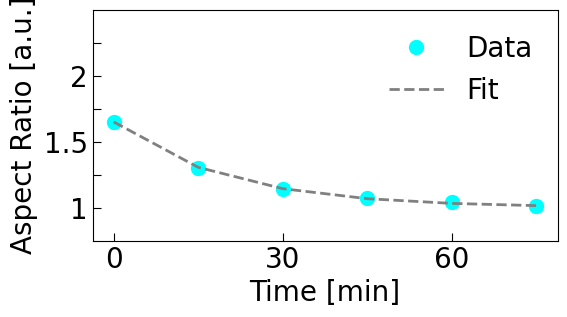

Initial size [um] =  26.738737399768652


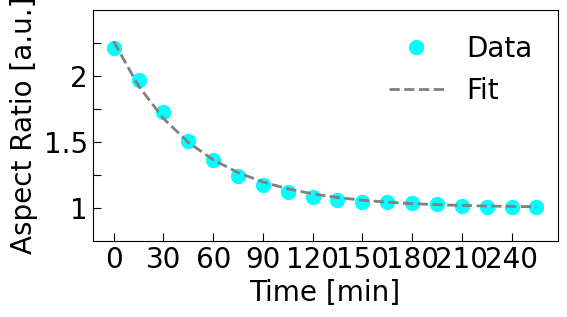

Initial size [um] =  43.822044452700545


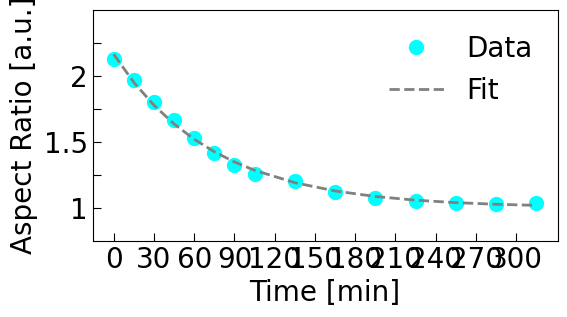

Initial size [um] =  58.0157397320432


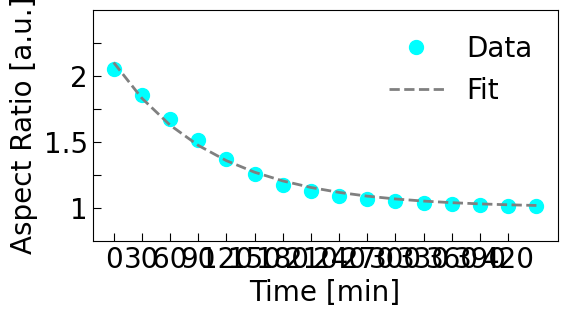

Initial size [um] =  81.03245617299638


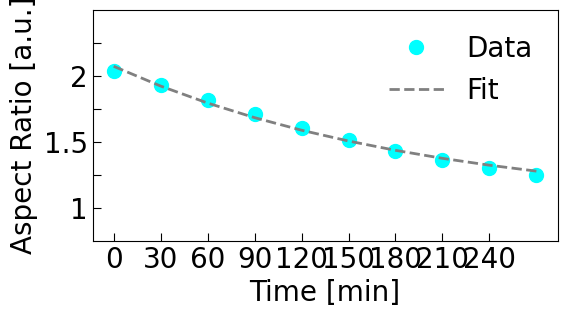

In [11]:
# Change directory into subdir of choice - here coalescence events for A condensates
os.chdir(COALESCENCE_EVENTS_B)

# Define files of interest
event_files_b = [
    'Coalescence_B_4_8.tif', 
    'Coalescence_B_6_12.tif', 
    'Coalescence_B_32_43.tif', 
    'Coalescence_B_78_98.tif', 
    'Coalescence_B_108_118.tif',
    'Coalescence_B_1_10_16.tif', 
    'Coalescence_B_1_21_39.tif', 
    'Coalescence_B_1_34_49.tif', 
    'Coalescence_B_1_79_95.tif', 
    'Coalescence_B_1_108_118.tif'
]
# Here, each file is as long as a pristine timelapse, but only contains the (manually) cropped region
# surrounding the pair of fusing droplets
# However, the fusion event is not that long!
# Manually checked the time ranges of the fusion event in each file -> event_ranges
# These are indices of timepoints, not time values themselves.
# Ranges in `event_ranges` are paired with `event_files`
event_ranges_b = [
    range(4, 9), 
    range(5, 12), 
    range(31, 43), 
    range(78, 98), 
    range(109, 118), 
    range(9, 16), 
    range(20, 39), 
    range(33, 49), 
    range(78, 95), 
    range(107, 118)
]

initial_sizes_b, taus_b = pipeline(
    event_files_b, event_ranges_b, 
    colour='cyan', label='B', 
    channels = {'red': False, 'green' : True, 'blue' : True},  # cyan as mix of green and blue
    plot=False,
)

# Results / Visualisation

A: LinregressResult(slope=127.39593473993132, intercept=-1108.8332865676393, rvalue=0.9799330148687131, pvalue=6.924843363952854e-07, stderr=9.161793516476104, intercept_stderr=448.6877980344679)
B: LinregressResult(slope=152.30168674089666, intercept=-1327.2228842881268, rvalue=0.9861237378863453, pvalue=1.5952102195859432e-07, stderr=9.064997838575316, intercept_stderr=438.56007372574754)


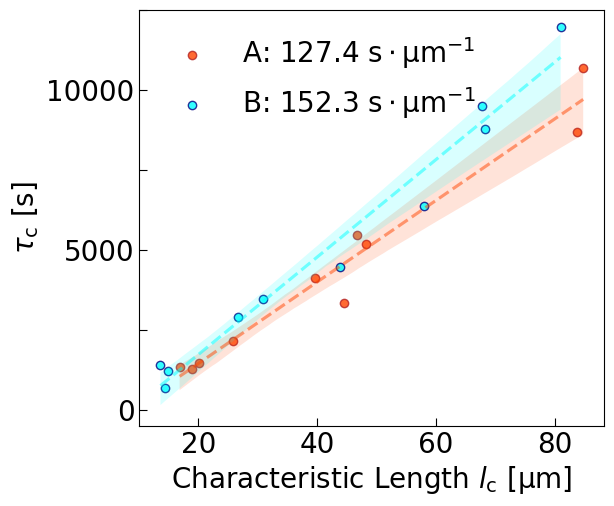

In [12]:
results = [
    linregress(x = initial_sizes, y = np.array(taus)*60)
    for initial_sizes, taus in zip([initial_sizes_a, initial_sizes_b], [taus_a, taus_b])

]
print(f"A: {results[0]}\nB: {results[1]}")

# Set up plot
plt.figure(figsize = (6, 5.4))
# convert taus from minutes to seconds: multiply by 60
# initial_sizes are already in micron (um)
sns.regplot(
    x = initial_sizes_a, 
    y = np.array(taus_a)*60, 
    color = 'orangered', 
    scatter_kws = {'ec' : 'firebrick'}, 
    line_kws = {'alpha' : 0.5, 'ls' : 'dashed'}, 
    label = 'A: ' + str(round(results[0].slope, 2)) + r' $\rm s \cdot \mu m^{-1}$'
)
sns.regplot(
    x = initial_sizes_b, 
    y = np.array(taus_b)*60, 
    color = 'cyan', 
    scatter_kws = {'ec' : 'navy'}, 
    line_kws = {'alpha' : 0.5, 'ls' : 'dashed'}, 
    label = 'B: ' + str(round(results[1].slope, 2)) + r' $\rm s \cdot \mu m^{-1}$'
)
plt.xlabel(
    r'Characteristic Length $l_{\rm c}$ [$\rm \mu$m]', 
    fontsize = 20
)
plt.xticks([20, 40, 60, 80], fontsize = 20)

plt.ylabel(
    r'$\tau_{\rm c}$ [s]', 
    fontsize = 20
)
plt.yticks(
    [0, 2500, 5000, 7500, 10000, 12500], 
    [0, '', 5000, '', 10000, ''], 
    fontsize = 20
)
plt.ylim([-500, 12500])
plt.legend(frameon = False, fontsize = 20)
plt.gca().tick_params(direction = 'in', length = 6)

# Re-enable to save regression plot in SVG format
# plt.savefig(RESULTS_DIR + 'sintering_analysis.svg')